<a href="https://colab.research.google.com/github/nhuang37/InvariantFeatures/blob/main/Pointcloud_GWdist_large_hidden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utils

In [1]:
!pip install torchmetrics

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/JHU/Group'

/content/drive/MyDrive/JHU/Group


In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import os.path as osp
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, zinc, QM7b, ModelNet
from torch_geometric.utils import to_networkx, homophily, erdos_renyi_graph, stochastic_blockmodel_graph, scatter, loop
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.nn.aggr import DeepSetsAggregation #key to implement DeepSet input (batch_features, batch_index)
from torch_geometric.nn.models import MLP
import torch.nn as nn
from torch.nn import Linear, Sequential, ReLU, Dropout
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch.optim import SGD
from tqdm.auto import tqdm

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
from torchmetrics.functional.pairwise import pairwise_euclidean_distance
from torchmetrics.regression import SpearmanCorrCoef
#reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

### (Invariant classification) Benchmark dataset: ModelNet40
- The most popular dataset for pointcloud classification
- Can benchmark against Deepset and PointNet (old SOTA models): e,g, https://github.com/manzilzaheer/DeepSets/blob/master/PointClouds/run.py
- BUG: relatively large point clouds, our methods need $O(n^2)$ computation whereas Deepset/PointNet can do $O(n)$ (since the point clouds literally live in $d=3$)
- Idea: compute distance to K-means centroids, not all pairs distance

[src1](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pyg/pointnet-classification/02_pointnet_plus_plus.ipynb#scrollTo=1724081c-235a-49ff-9d1f-0ec2e06e1a4e);
[src2](https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
#load targets from GWdistance
import pickle
epsilon=0.01
classes=[2, 7]
num_pointclouds=40 #per class
rank=-1
sample_points=100
_, xtrain_s, ytrain_s, xtest_s, ytest_s, indices, indices_test, converged, elapsed = pickle.load(
                                                         open(f"GW_points{sample_points}_epsilon{epsilon}_classes[2, 7]_clouds_{num_pointclouds}_rank-1.pkl", "rb"))

In [8]:
def get_fs(X):
  '''
  input: X (n by 3)
  output: Data (class) storing fs (n by (n + n(n-1)/2 + 1)) feature matrix
   f_d is the set of diagonal edge attributes,
   f_o is the set of off-diagonal (upper) edge attributes,
   f_star is \sum_{i \neq j} X_ii X_ij where X is the n by n edge attribute graph
  '''
  n = X.shape[0]
  data = Data()
  Gram = torch.FloatTensor(X @ X.T)
  off_mask = torch.triu(torch.ones(n, n)) == 1

  data.f_d = torch.diagonal(Gram, 0).unsqueeze(1)
  data.f_o = Gram[off_mask].unsqueeze(1)
  data.f_star = (data.f_d * (torch.sum(Gram, dim=1, keepdim=True) - data.f_d)).sum().reshape((1,1))

  return data

def get_Kmeans(X, k=3):
  '''
  Implement eqn 6: replace f_d as the self-dots of the K-means dots
  input: X (n by 3), k: number of k-means clusters
  output: Data (class) storing  feature matrix
   f_d is the flattened feature of the gram matrix of K-means centroids
   f_o is the set of dot products of each point to the K-means centroids
  '''
  n = X.shape[0]
  data = Data()

  kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++', n_init=1).fit(X)
  K = kmeans.cluster_centers_ #(num_centroids, 3)
  #sort Kmeans centroid by norm
  indexlist = np.argsort(np.linalg.norm(K,axis=1))
  K = K[indexlist,:]
  data.f_o = torch.FloatTensor( X @ K.T) #shape(n, d)
  Gram_k = torch.FloatTensor( K @ K.T ) #shape (d, d)
  data.f_d = Gram_k.reshape(1, k*k) #shape (d^2,)
  return data

In [9]:
def build_dataset(xtrain_s, xtest_s, ids, Kmeans=False, k=3):
  X_train = []
  X_test = []
  for i in ids:
    if Kmeans:
      X_train.append(get_Kmeans(xtrain_s[i],k=k))
      X_test.append(get_Kmeans(xtest_s[i],k=k))
    else:
      X_train.append(get_fs(xtrain_s[i]))
      X_test.append(get_fs(xtest_s[i]))

  return X_train, X_test


def get_loaders(train_data1, test_data1, train_data2, test_data2, batch_size, follow_batch=None):
  '''
  data1, data2 refers to subsets in ModelNet10 belonging to two different classes
  '''

  train_loader1 = DataLoader(
      train_data1,
      batch_size=batch_size,
      shuffle=False,
      follow_batch=follow_batch
  )
  train_loader2 = DataLoader(
      train_data2,
      batch_size=batch_size,
      shuffle=False,
      follow_batch=follow_batch
  )

  test_loader1 = DataLoader(
      test_data1,
      batch_size=batch_size,
      shuffle=False,
      follow_batch=follow_batch
  )

  test_loader2 = DataLoader(
      test_data2,
      batch_size=batch_size,
      shuffle=False,
      follow_batch=follow_batch
  )

  return train_loader1, train_loader2, test_loader1, test_loader2

In [10]:
n_train = len(xtrain_s)
n_test = len(xtest_s)
bs = 40
###OLD: gw solver
#D = torch.FloatTensor(D)
#dist_true_train = D[:k,k:(2*k)].flatten().unsqueeze(1)
#dist_true_test = D[(2*k):(3*k),(3*k):(4*k)].flatten().unsqueeze(1)

###UPDATED 1/16/2024: gw lowerbound
dist_true_train = pickle.load(open("LB_GW_train.pkl", "rb"))
dist_true_train = torch.from_numpy(np.array(dist_true_train)).unsqueeze(1)
dist_true_test = pickle.load(open("LB_GW_test.pkl", "rb"))
dist_true_test = torch.from_numpy(np.array(dist_true_test)).unsqueeze(1)

In [11]:
dist_true_train.shape, dist_true_test.shape #cross-distance, no need to upper triangular mask (non-symmetric)

(torch.Size([1600, 1]), torch.Size([1600, 1]))

### ScalarModel

In [12]:
class ScalarModel(torch.nn.Module):
    def __init__(self, hid_dim_d, hid_dim_o, out_dim, dropout=0, input_dim=1, input_off=1):
        '''
        For all off-diag scalars, input_off = 1
        '''
        super(ScalarModel, self).__init__()
        #Deepset for diagonal scalars
        phi_d = MLP([input_dim,hid_dim_d//2, hid_dim_d], dropout=[dropout]*2)
        rho_d = MLP([hid_dim_d, hid_dim_d//2], dropout=[dropout]*1) #MLP([hid_dim*2, hid_dim, hid_dim], dropout=[dropout]*2) #
        self.deepset_d = DeepSetsAggregation(local_nn=phi_d, global_nn=rho_d)
        #Deepset for off-diagonal scalars
        phi_o = MLP([input_off,hid_dim_o//2, hid_dim_o], dropout=[dropout]*2)
        rho_o = MLP([hid_dim_o, hid_dim_o//2], dropout=[dropout]*1) #MLP([hid_dim*2, hid_dim, hid_dim], dropout=[dropout]*2)
        self.deepset_o = DeepSetsAggregation(local_nn=phi_o, global_nn=rho_o)
        #MLP_s for f_star
        #self.MLP_s = MLP([input_dim,hid_dim, hid_dim], dropout=[dropout]*2)  #MLP([1,hid_dim*2, hid_dim], dropout=[dropout]*2) #
        #MLP for (Deepset(f_d), Deepset(f_o), f_star)
        self.MLP_out = MLP([hid_dim_d//2 + hid_dim_o//2 +input_dim, hid_dim_d//2, out_dim], dropout=[dropout]*2)
        self.out_dim = out_dim

    def reset_parameters(self):
        #for net in [self.deepset_d, self.deepset_o, self.MLP_s, self.MLP_out]:
        for net in [self.deepset_d, self.deepset_o, self.MLP_out]:
            net.reset_parameters()

    def forward(self, data):
        out_d = self.deepset_d(data.f_d, data.f_d_batch) # bs x hid_dim
        out_o = self.deepset_o(data.f_o, data.f_o_batch) # bs x hid_dim
        #out_star = self.MLP_s(data.f_star) #bs x hid_dim
        #concat and output final embedding
        out = self.MLP_out(torch.concat([out_d, out_o, data.f_star], dim=-1)) # bs x hid_dim*3 -> bs x out_dim
        return out

In [142]:
class ScalarModel_KMeans(torch.nn.Module):
    def __init__(self, hid_dim, out_dim, dropout=0, input_dim=9, input_off=3):
        '''
        input_dim = d^2
        input_off = d
        '''
        super(ScalarModel_KMeans, self).__init__()
        #MLP for k-means gram matrix, C(Y) C(Y)^T
        self.MLP_km = MLP([input_dim, input_dim*2, input_dim], dropout=[dropout]*2)
        #Deepset for k-means features, C(Y) Y (action on the n points in R^d)
        phi_o = MLP([input_off, hid_dim//2, hid_dim], dropout=[dropout]*2)
        rho_o = MLP([hid_dim, input_dim*2], dropout=[dropout]*1) #MLP([hid_dim*2, hid_dim, hid_dim], dropout=[dropout]*2)
        self.deepset_o = DeepSetsAggregation(local_nn=phi_o, global_nn=rho_o)
        #MLP for (MLP_km(f_km), Deepset(f_d))
        self.MLP_out = MLP([input_dim*3, input_dim*3, out_dim], dropout=[dropout]*2)
        self.out_dim = out_dim

    def reset_parameters(self):
        #for net in [self.deepset_o, self.MLP_out]:
        for net in [self.MLP_km, self.deepset_o, self.MLP_out]:
            net.reset_parameters()

    def forward(self, data):
        out_d = self.MLP_km(data.f_d, data.f_d_batch) # bs x hid_dim
        out_o = self.deepset_o(data.f_o, data.f_o_batch) # bs x hid_dim
        #concat and output final embedding
        out = self.MLP_out(torch.concat([out_d, out_o], dim=-1)) # bs x hid_dim*2 -> bs x out_dim
        return out

In [14]:
#cf: metric learning https://en.wikipedia.org/wiki/Similarity_learning
class SiameseRegressor(torch.nn.Module):
    def __init__(self, ScalarModel):
        super(SiameseRegressor, self).__init__()
        self.SM = ScalarModel
        #metric learning (TODO: should we do this for the GW dist instead?)
        self.metric = nn.Linear(self.SM.out_dim, self.SM.out_dim, bias=False)
        self.metric.reset_parameters()
        self.linear = nn.Linear(1,1)
        self.linear.reset_parameters()

    def forward(self, x1, x2):
        n = x1.num_graphs
        emb1 = self.SM(x1) #n by out_dim
        emb2 = self.SM(x2) #n by out_dim
        emb1 = self.metric(emb1) # project
        emb2 = self.metric(emb2) #project
        dist_mat = pairwise_euclidean_distance(emb1, emb2) #n by n matrix
        dist_vec = dist_mat.flatten().unsqueeze(1)
        dist_pred = self.linear(dist_vec)
        return dist_pred

In [15]:
def train(model, optimizer, criterion, loader1, loader2, dist_true):
    model.train()

    total_loss = 0
    for data1, data2 in zip(loader1, loader2):
        data1 = data1.to(device)
        data2 = data2.to(device)
        optimizer.zero_grad()  # Clear gradients.
        dist_pred = model(data1, data2)  # Forward pass.
        loss = criterion(dist_pred, dist_true)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item()

    return total_loss / len(loader1)


@torch.no_grad()
def test(model, criterion, loader1, loader2, dist_true):
    model.eval()

    total_loss = 0
    for data1, data2 in zip(loader1, loader2):
        data1 = data1.to(device)
        data2 = data2.to(device)
        dist_pred = model(data1, data2)  # Forward pass.
        loss = criterion(dist_pred, dist_true)  # Loss computation.
        total_loss += loss.item()

    return total_loss / len(loader1)


In [16]:
idx1 = np.where(np.array(ytrain_s)==2)[0]
idx2 = np.where(np.array(ytrain_s)==7)[0]
X_train1, X_test1 = build_dataset(xtrain_s, xtest_s, idx1)
X_train2, X_test2 = build_dataset(xtrain_s, xtest_s, idx2)

In [17]:
len(idx1), len(X_train1)

(40, 40)

In [18]:
train_loader1, train_loader2, test_loader1, test_loader2 = get_loaders(X_train1, X_test1, X_train2, X_test2, batch_size=bs, follow_batch=['f_d','f_o'])

In [24]:
hid_dim_d = 100 #16
hid_dim_o = 100
out_dim = 16
dropout = 0.1
scalar = ScalarModel(hid_dim_d, hid_dim_o, out_dim, input_dim=1, dropout=dropout)
model = SiameseRegressor(scalar)
model = model.to(device)
print(model)

model.SM.reset_parameters()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam([{'params': model.SM.parameters()},
                             {'params': model.metric.parameters(), 'lr': 1e-2},
                             {'params': model.linear.parameters(), 'lr': 1e-2},
                              ], lr=1e-3)
criterion = torch.nn.MSELoss()  # Define loss criterion.

for epoch in range(1, 201):
    train_loss = train(model, optimizer, criterion, train_loader1, train_loader2, dist_true_train.to(device))
    #scheduler.step(loss)
    test_loss = test(model, criterion, test_loader1, test_loader2, dist_true_test.to(device))
    if epoch %10 == 0:
      print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


SiameseRegressor(
  (SM): ScalarModel(
    (deepset_d): DeepSetsAggregation(local_nn=MLP(1, 50, 100), global_nn=MLP(100, 50))
    (deepset_o): DeepSetsAggregation(local_nn=MLP(1, 50, 100), global_nn=MLP(100, 50))
    (MLP_out): MLP(101, 50, 16)
  )
  (metric): Linear(in_features=16, out_features=16, bias=False)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Epoch: 10, Loss: 0.5825, Test Loss: 0.6190
Epoch: 20, Loss: 0.3943, Test Loss: 0.4683
Epoch: 30, Loss: 0.2879, Test Loss: 0.3634
Epoch: 40, Loss: 0.2115, Test Loss: 0.2832
Epoch: 50, Loss: 0.1544, Test Loss: 0.2214
Epoch: 60, Loss: 0.1107, Test Loss: 0.1720
Epoch: 70, Loss: 0.0744, Test Loss: 0.1244
Epoch: 80, Loss: 0.0388, Test Loss: 0.0713
Epoch: 90, Loss: 0.0375, Test Loss: 0.0371
Epoch: 100, Loss: 0.0264, Test Loss: 0.0361
Epoch: 110, Loss: 0.0242, Test Loss: 0.0319
Epoch: 120, Loss: 0.0249, Test Loss: 0.0265
Epoch: 130, Loss: 0.0210, Test Loss: 0.0218
Epoch: 140, Loss: 0.0187, Test Loss: 0.0207
Epoch: 150, Loss:

In [25]:
def evaluate_dist_mat(model,loader1, loader2):
  model.eval()
  data1 = next(iter(loader1)).to(device)
  data2 = next(iter(loader2)).to(device)
  dist_vec = model(data1, data2).detach().cpu()
  n = data1.num_graphs
  dist_mat = torch.unflatten(dist_vec, 0, (n, n))
  return dist_mat

In [26]:
D_pred_train = evaluate_dist_mat(model, train_loader1, train_loader2)
D_pred_test = evaluate_dist_mat(model, test_loader1, test_loader2)


In [27]:
spearman = SpearmanCorrCoef()
rank_corr_train = spearman(D_pred_train.reshape(-1,1), dist_true_train)
rank_corr_test = spearman(D_pred_test.reshape(-1,1), dist_true_test)

In [28]:
rank_corr_train, rank_corr_test

(tensor(0.9456), tensor(0.9230))

### Kmeans run

In [30]:
X_train1_km, X_test1_km = build_dataset(xtrain_s, xtest_s, idx1, Kmeans=True, k=3)
X_train2_km, X_test2_km = build_dataset(xtrain_s, xtest_s, idx2, Kmeans=True, k=3)

In [31]:
train_loader1_km, train_loader2_km, test_loader1_km, test_loader2_km = get_loaders(X_train1_km, X_test1_km,
                                                                                   X_train2_km, X_test2_km, batch_size=bs, follow_batch=['f_d','f_o'])
next(iter(train_loader1_km))

DataBatch(f_o=[4000, 3], f_o_batch=[4000], f_o_ptr=[41], f_d=[40, 9], f_d_batch=[40], f_d_ptr=[41])

In [201]:
hid_dim = 128 #64 #16
out_dim = 16
dropout = 0.1
scalar_km = ScalarModel_KMeans(hid_dim, out_dim, input_dim=9, input_off=3, dropout=dropout)
model_km = SiameseRegressor(scalar_km)
model_km = model_km.to(device)
print(model_km)
model_km.SM.reset_parameters()
#optimizer = torch.optim.Adam(model_km.parameters(), lr=0.001)
optimizer = torch.optim.Adam([{'params': model_km.SM.parameters()},
                             {'params': model_km.metric.parameters(), 'lr': 1e-2},
                             {'params': model_km.linear.parameters(), 'lr': 1e-2},
                              ], lr=5e-4, weight_decay=1e-4)
criterion = torch.nn.MSELoss()  # Define loss criterion.

for epoch in range(1, 201):
    train_loss = train(model_km, optimizer, criterion, train_loader1_km, train_loader2_km, dist_true_train.to(device))
    #scheduler.step(loss)
    test_loss = test(model_km, criterion, test_loader1_km, test_loader2_km, dist_true_test.to(device))
    if epoch %10 == 0:
      print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

SiameseRegressor(
  (SM): ScalarModel_KMeans(
    (MLP_km): MLP(9, 18, 9)
    (deepset_o): DeepSetsAggregation(local_nn=MLP(3, 64, 128), global_nn=MLP(128, 18))
    (MLP_out): MLP(27, 27, 16)
  )
  (metric): Linear(in_features=16, out_features=16, bias=False)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Epoch: 10, Loss: 1.2924, Test Loss: 1.4257
Epoch: 20, Loss: 0.9159, Test Loss: 1.0265
Epoch: 30, Loss: 0.2810, Test Loss: 0.2488
Epoch: 40, Loss: 0.1450, Test Loss: 0.0933
Epoch: 50, Loss: 0.1011, Test Loss: 0.1075
Epoch: 60, Loss: 0.0946, Test Loss: 0.0912
Epoch: 70, Loss: 0.0778, Test Loss: 0.0907
Epoch: 80, Loss: 0.0697, Test Loss: 0.0893
Epoch: 90, Loss: 0.0557, Test Loss: 0.0721
Epoch: 100, Loss: 0.0720, Test Loss: 0.0656
Epoch: 110, Loss: 0.0598, Test Loss: 0.0825
Epoch: 120, Loss: 0.0572, Test Loss: 0.0671
Epoch: 130, Loss: 0.0544, Test Loss: 0.0701
Epoch: 140, Loss: 0.0497, Test Loss: 0.0611
Epoch: 150, Loss: 0.0429, Test Loss: 0.0547
Epoch: 160, Loss: 0.0512, 

In [202]:
D_pred_train_km = evaluate_dist_mat(model_km, train_loader1_km, train_loader2_km)
D_pred_test_km = evaluate_dist_mat(model_km, test_loader1_km, test_loader2_km)

In [203]:
rank_corr_train_km = spearman(D_pred_train_km.reshape(-1,1), dist_true_train)
rank_corr_test_km = spearman(D_pred_test_km.reshape(-1,1), dist_true_test)
rank_corr_train_km, rank_corr_test_km

(tensor(0.7105), tensor(0.7291))

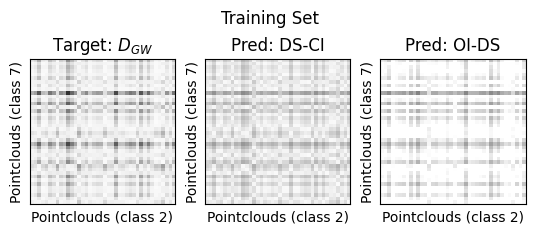

In [205]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True)
#axs[0].imshow(D[:k,k:(2*k)], cmap="binary", origin="lower")
axs[0].imshow(torch.unflatten(dist_true_train, 0, (40,40)), cmap="binary", origin="lower", vmin=0, vmax=2)
axs[1].imshow(D_pred_train, cmap="binary", origin="lower", vmin=0, vmax=2)
axs[2].imshow(D_pred_train_km, cmap="binary", origin="lower", vmin=0, vmax=2)
axs[0].set_title(r"Target: $D_{GW}$")
axs[1].set_title(r"Pred: DS-CI")
axs[2].set_title(r"Pred: OI-DS")
for ax in axs:
  ax.set_xlabel("Pointclouds (class 2)")
  ax.set_ylabel("Pointclouds (class 7)")
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

fig.suptitle("Training Set", y=0.75)
plt.show()

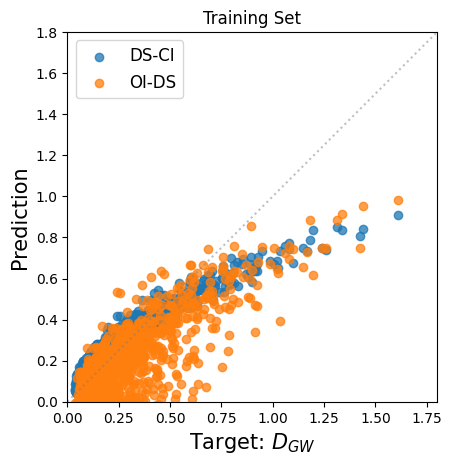

In [206]:
plt.scatter(dist_true_train[:,0], D_pred_train.flatten(), label="DS-CI", alpha=0.75)
plt.scatter(dist_true_train[:,0], D_pred_train_km.flatten(), label="OI-DS", alpha=0.75)
plt.plot(np.linspace(0,1.8,100),np.linspace(0,1.8,100), ls=":", color="gray", alpha=0.5)
plt.xlabel(r"Target: $D_{GW}$", fontsize=15)
plt.ylabel(r"Prediction", fontsize=15)
plt.title("Training Set")
plt.legend(fontsize=12)
plt.xlim(0,1.8)
plt.ylim(0,1.8)
plt.gca().set_aspect('equal')


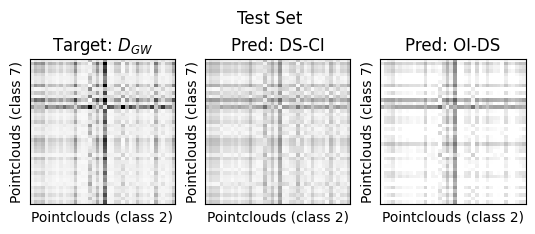

In [207]:
fig, axs = plt.subplots(ncols=3)
axs[0].imshow(torch.unflatten(dist_true_test, 0, (40,40)), cmap="binary", origin="lower", vmin=0, vmax=2)
#axs[0].imshow(D[2*k:3*k, 3*k:4*k], cmap="binary", origin="lower")
axs[1].imshow(D_pred_test, cmap="binary", origin="lower", vmin=0, vmax=2)
axs[2].imshow(D_pred_test_km, cmap="binary", origin="lower", vmin=0, vmax=2)
axs[0].set_title(r"Target: $D_{GW}$")
axs[1].set_title(r"Pred: DS-CI")
axs[2].set_title(r"Pred: OI-DS")
for ax in axs:
  ax.set_xlabel("Pointclouds (class 2)")
  ax.set_ylabel("Pointclouds (class 7)")
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])
fig.suptitle("Test Set", y=0.75)
plt.show()

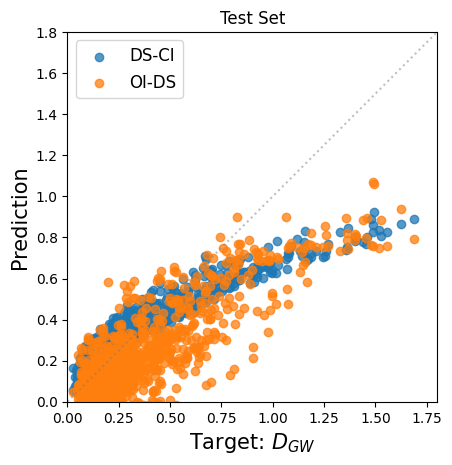

In [208]:
plt.scatter(dist_true_test[:,0], D_pred_test.flatten(), label="DS-CI", alpha=0.75)
plt.scatter(dist_true_test[:,0], D_pred_test_km.flatten(), label="OI-DS", alpha=0.75)
plt.plot(np.linspace(0,1.8,100),np.linspace(0,1.8,100), ls=":", color="gray", alpha=0.5)
plt.xlabel(r"Target: $D_{GW}$", fontsize=15)
plt.ylabel(r"Prediction", fontsize=15)
plt.title("Test Set")
plt.legend(fontsize=12)
plt.xlim(0,1.8)
plt.ylim(0,1.8)
plt.gca().set_aspect('equal')

In [204]:
#plot true dist vs pred dist
#try 200 sampling points
#save models
torch.save(model.state_dict(), './models/scalarmodel_d100.pt')
torch.save(model_km.state_dict(), './models/scalarmodel_kmeans_d128.pt')


### Reload models

In [ ]:
hid_dim = 16
out_dim = 8
scalar_km_re = ScalarModel_KMeans(hid_dim, out_dim, input_dim=9, input_off=3)
model_km_reload = SiameseRegressor(scalar_km_re)
model_km_reload = model_km_reload.to(device)
model_km_reload.load_state_dict(torch.load('./models/scalarmodel_kmeans.pt'))
# model_km_reload.eval()

D_pred_train_km = evaluate_dist_mat(model_km_reload, train_loader1_km, train_loader2_km)
D_pred_test_km = evaluate_dist_mat(model_km_reload, test_loader1_km, test_loader2_km)

In [ ]:
spearman = SpearmanCorrCoef()
rank_corr_train_km = spearman(D_pred_train_km.reshape(-1,1), dist_true_train)
rank_corr_test_km = spearman(D_pred_test_km.reshape(-1,1), dist_true_test)
rank_corr_train_km, rank_corr_test_km

(tensor(0.8022), tensor(0.7490))

In [ ]:
hid_dim = 16
out_dim = 16
scalar = ScalarModel(hid_dim, out_dim, input_dim=1)
model = SiameseRegressor(scalar)
model = model.to(device)
model.load_state_dict(torch.load('./models/scalarmodel.pt'))

D_pred_train = evaluate_dist_mat(model, train_loader1, train_loader2)
D_pred_test = evaluate_dist_mat(model, test_loader1, test_loader2)
rank_corr_train = spearman(D_pred_train.reshape(-1,1), dist_true_train)
rank_corr_test = spearman(D_pred_test.reshape(-1,1), dist_true_test)
rank_corr_train, rank_corr_test

(tensor(0.8806), tensor(0.8550))